In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# GenAI for Marketing Image - Place Logo & Text Overlays

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/language/use-cases/gen-ai-marketing-image-overlay/Overlay_Asset.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/use-cases/gen-ai-marketing-image-overlay/Overlay_Asset.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/language/use-cases/gen-ai-marketing-image-overlay/Overlay_Asset.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


| | |
|-|-|
|Author(s) | [Rohit Naidu](https://github.com/rohitnaiduG) |
|Author(s) | [Suddhasatwa Bhaumik](https://github.com/suddhasatwabhaumik) |

## Overview

- We want to add multiple overlays to the Images Generated by Imagen for Marketing purposes like Add Logo or Text
- We want to add the Brand Logo at one of the corners, resize etc.
- We want to add Text in a particular Font, Position, Size & Colour etc. to the Image.
- These tasks should not modify the Original Image, rather add layers.
- We solve this using Generative Code from Text Instructions using Code Bison.
- We Prompt the Model with a base code and the desired Tasks eg: Make logo Transparent
- CodeBison will return executable Python code
- We immediately execute this code and validate the Output
- Repeat the process till the output is as expected.
- Final code is saved for apllying consistently to multiple Images

[CodeBison on Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/code-generation) (Code Generative AI) offers a variety of features:
- Unit tests: Use the prompt to request a unit test for a function.
- Write a function: Pass a problem to the model to get a function that solves that problem.
- Create a class: Use a prompt to describe the purpose of a class and have code that defines the class returned.
This notebook focuses on **applying code generation for image overlays** only.

### Objectives

In this notebook, you will learn how to use the Vertex AI Python SDK to:

- Adding logo, overlay and text at the same exact place is not a Generative task.
- We need something more Deterministic to do this repetitively at scale
- All we have are Rules in raw text that describe the intent of the task
- We use this text to create a Prompt for Google's CodeBison model
- CodeBison model is designed to Generate code given Text desciptions
- We ask the model for working Python code and it delivers.
- We test output the code, and if it doesnt work as expected, we again prompt the model to modify the Code.
- The model interactively keeps updating the code. It can also fix Errors that we encounter.
- Finally, the working code that suits our task is saved and we can use this same code for any number of images.

### Costs

This tutorial uses billable components of Google Cloud:
- Vertex AI (Code Bison)

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started

### Install Vertex AI SDK, other packages and their dependencies

In [2]:
# !pip install --upgrade --user google-cloud-aiplatform
# !gcloud auth application-default login

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, you will need to authenticate your environment. To do this, run the new cell below. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [3]:
import sys

if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

In [4]:
from google.cloud import storage
import os
import time
import shutil
import importlib

In [5]:
import vertexai
from vertexai.language_models import CodeGenerationModel

### Define Google Cloud project information and initialize Vertex AI

Initialize the Vertex AI SDK for Python for your project:

In [6]:
PROJECT_ID = "overlay-411608"
LOCATION = "us-central1"

In [7]:
vertexai.init(project=PROJECT_ID, location=LOCATION)

### Utility Code 

In [8]:
def get_assets(bucketname, config):
    """
    Read Images, Fonts etc from GCS buckets
    """
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucketname)

    try:
        os.mkdir("./tmp")
    except OSError as error:
        pass

    for key in ["image_path", "logo_path", "font_path"]:
        blob = bucket.blob(config[key])
        filename = config[key].split("/")[-1]
        blob.download_to_filename(f"./tmp/{filename}")

In [9]:
def upload_output(bucketname, op_local_path, output_path):
    """
    Upload Final Image to GCS bucket
    """
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucketname)

    blob = bucket.blob(output_path)
    blob.upload_from_filename(op_local_path)

    # Delete the temporary files
    shutil.rmtree("./tmp", ignore_errors=True)

### Generate Code to Edit Image Using LLM

- We create a module that defines the function call signature as starting point
- Then we ask Code Bison to modify the code to perform the Task we like
    - Eg: Make the Logo Transparent
- The model gives us working Python code which we save in a temp file.
- This can now be imported and executed directly

In [10]:
def generate_code(base_code="gen_code.py", updated_code="gen_code_tmp.py", prompt=""):

    with open(base_code, "r") as file:
        base_code_contents = file.read()

    prompt = prompt + "\n" + base_code_contents

    parameters = {"candidate_count": 1, "max_output_tokens": 1024, "temperature": 0.9}
    model = CodeGenerationModel.from_pretrained("code-bison")

    response = model.predict(prefix=prompt, **parameters)

    lines = response.text.splitlines()
    filtered_lines = []
    for line in lines:
        if not line.startswith("`"):
            filtered_lines.append(line)

    final_code = "\n".join(filtered_lines)
    print(f"Response from Model:\n{final_code}")

    with open(updated_code, "w") as file:
        file.write(final_code)

### Executed Generated Code with Config

- We reload the updated code and Execute it immediately
- If any errors are thrown, we can pass that to the model again

In [11]:
def run_generated_code(**config):

    # Generate New Code
    if config["generate_code"] == True:
        generate_code(
            base_code=config["base_code"],
            updated_code=config["updated_code"],
            prompt=config["prompt"],
        )
        module_path = config["updated_code"]
    else:
        module_path = config["base_code"]

    # Reload the generated code to execute
    module_name = os.path.splitext(os.path.basename(module_path))[0]
    try:
        module = importlib.import_module(module_name)
    except ModuleNotFoundError:
        module = importlib.import_module(module_name)  # Initial import
    else:
        module = importlib.reload(module)  # Reload if already imported

    # Run the generated code
    response = module.run_pipeline(**config)

    return response

### Run Pipeline

- The below code helps us to:
    - Read our Image & Assets from GCS and store locally
    - Execute generated code on the assets
    - Upload Output file back to GCS

In [12]:
def main(**config):
    # Fetch the Assets & Image
    get_assets(config["bucketname"], config)

    # Generate unique Output file name
    output_file = int(time.time())
    config["output_path"] = (
        config["output_path"].split(".png")[0] + f"_{output_file}.png"
    )

    # Use Local Path instead of GCS path
    local_config = config.copy()
    for key in local_config.keys():
        if "_path" in key:
            local_config[key] = f'./tmp/{config[key].split("/")[-1]}'

    # Run the code Generated by CodeBison
    response = run_generated_code(**local_config)

    # Upload Final Output to GCS
    upload_output(
        config["bucketname"], local_config["output_path"], config["output_path"]
    )
    print("Pipeline Completed Successfully!")

    return response

In [13]:
config = {
    "bucketname": "test-overlay",
    "image_path": "google/images/image5.png",
    "output_path": "google/outputs/generated.png",
    "logo_path": "google/assets/google-logo-9808.png",
    "font_path": "google/assets/Roboto-Bold.ttf", 
    "corner": "top right",
    "text": "We are testing this out!",
    "padding": 20,
    "font_size": 60,
    "color": (135, 206, 235),
    "position": (100, 100),
    "generate_code": True,
    "base_code": "gen_code.py",
    "updated_code": "gen_code_tmp.py",
    "prompt": """
    The following Python code adds a logo and text to an Image.
    User will call the run_pipeline() function. 
    modify the add_logo function to make the logo 50% transparent.
    Keep everything else same and make minimum changes.
    """,
}

### Response Generated

- We can validate the Generated code
- We can validate the generated Output

In [14]:
response = main(**config)

Response from Model:
from PIL import Image, ImageColor, ImageFont, ImageDraw


def add_logo(image, logo_path, corner, padding):
    """Adds the  logo to one of the corners of an image."""

    # Load the  logo image.
    logo = Image.open(logo_path)

    # Resize the  logo image to be 10% of the image height.
    logo = logo.resize((int(image.height * 0.1), int(image.height * 0.1)))

    # Make the logo 50% transparent.
    logo.putalpha(128)

    # Add the  logo image to the specified corner of the original image.
    if corner == "top left":
        image.paste(logo, (padding, padding), logo)
    elif corner == "top right":
        image.paste(logo, (image.width - logo.width - padding, padding), logo)
    elif corner == "bottom left":
        image.paste(logo, (padding, image.height - logo.height - padding), logo)
    elif corner == "bottom right":
        image.paste(
            logo,
            (image.width - logo.width - padding, image.height - logo.height - padding),
          

### Verify the Overlays

- As we can see below, the Logo has been place in the top right corner
- The Logo has been resized
_ The Logo is transparent
- The Text is printed on the image
- The Text has appropriate Size, Colour, Font etc.
- ***The Original Image has not been Modified at all.***

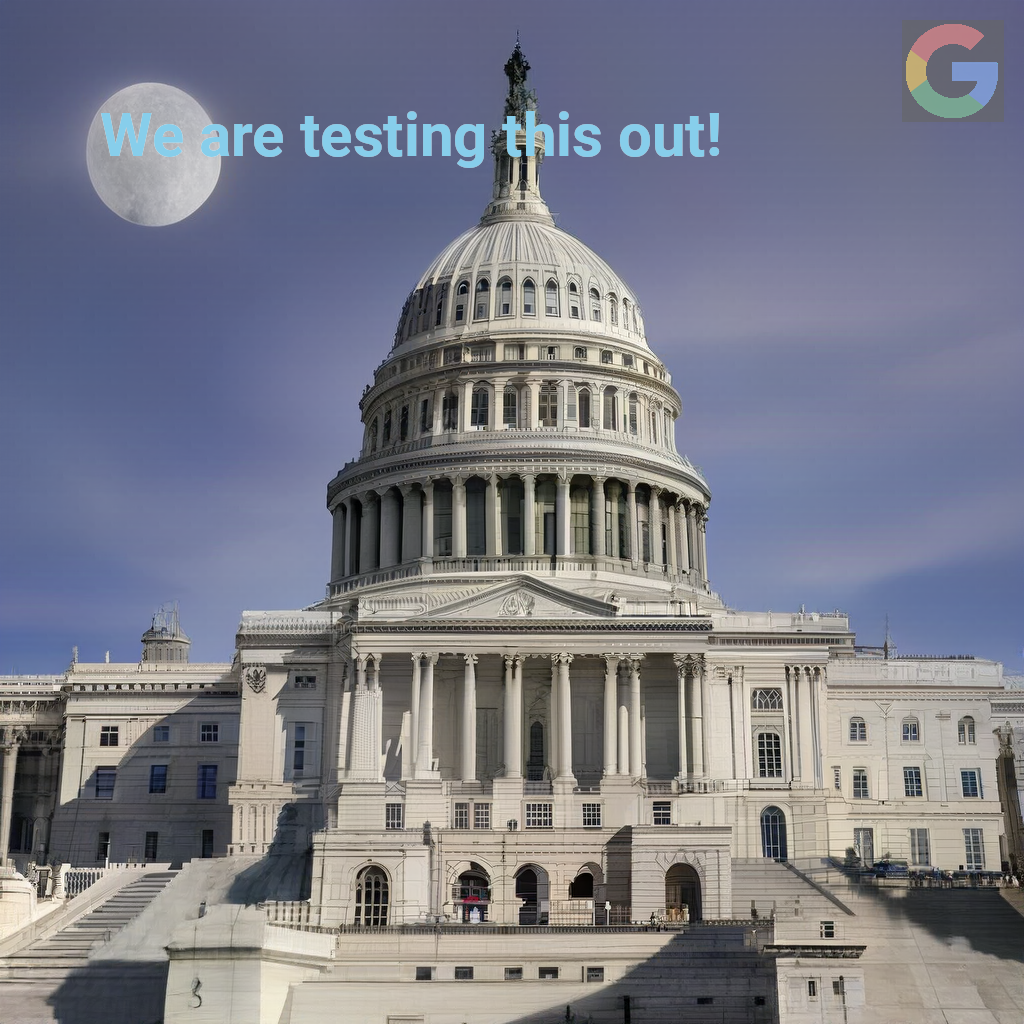

In [15]:
response

# Conclusion

* The Original Python Function Does not make Logo Transparent
* The New Code works directly end-to-end
* It does the necessary tasks that we have asked it to do ie. Make Logo Transparent
* It respects the function signatures and does not break the working code
* It makes minimal changes to existing code.
* ***The Original Image has not been Modified at all.***